In [ ]:
from torchvision import transforms
from PIL import Image
import torch
import csv
import os
import fiftyone as fo
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

/Users/xkaria/anaconda3/envs/image-extractor-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from feature_extractor import *
from find_neighbours import *
from tag_generator import *

In [3]:
path = './data/test'
dataset = create_dataset(path, 'dataset')

 100% |█████████████████| 165/165 [24.9ms elapsed, 0s remaining, 6.6K samples/s]   


In [4]:
dataset = load_dataset('dataset')

In [5]:
# Load the model
# Default model is vit_base_patch16_224 but you can change it to any model from the list
model = load_model()

In [6]:
embeddings = compute_embeddings(dataset, model)

Computing embeddings...
 100% |█████████████████| 165/165 [1.6m elapsed, 0s remaining, 1.7 samples/s]      



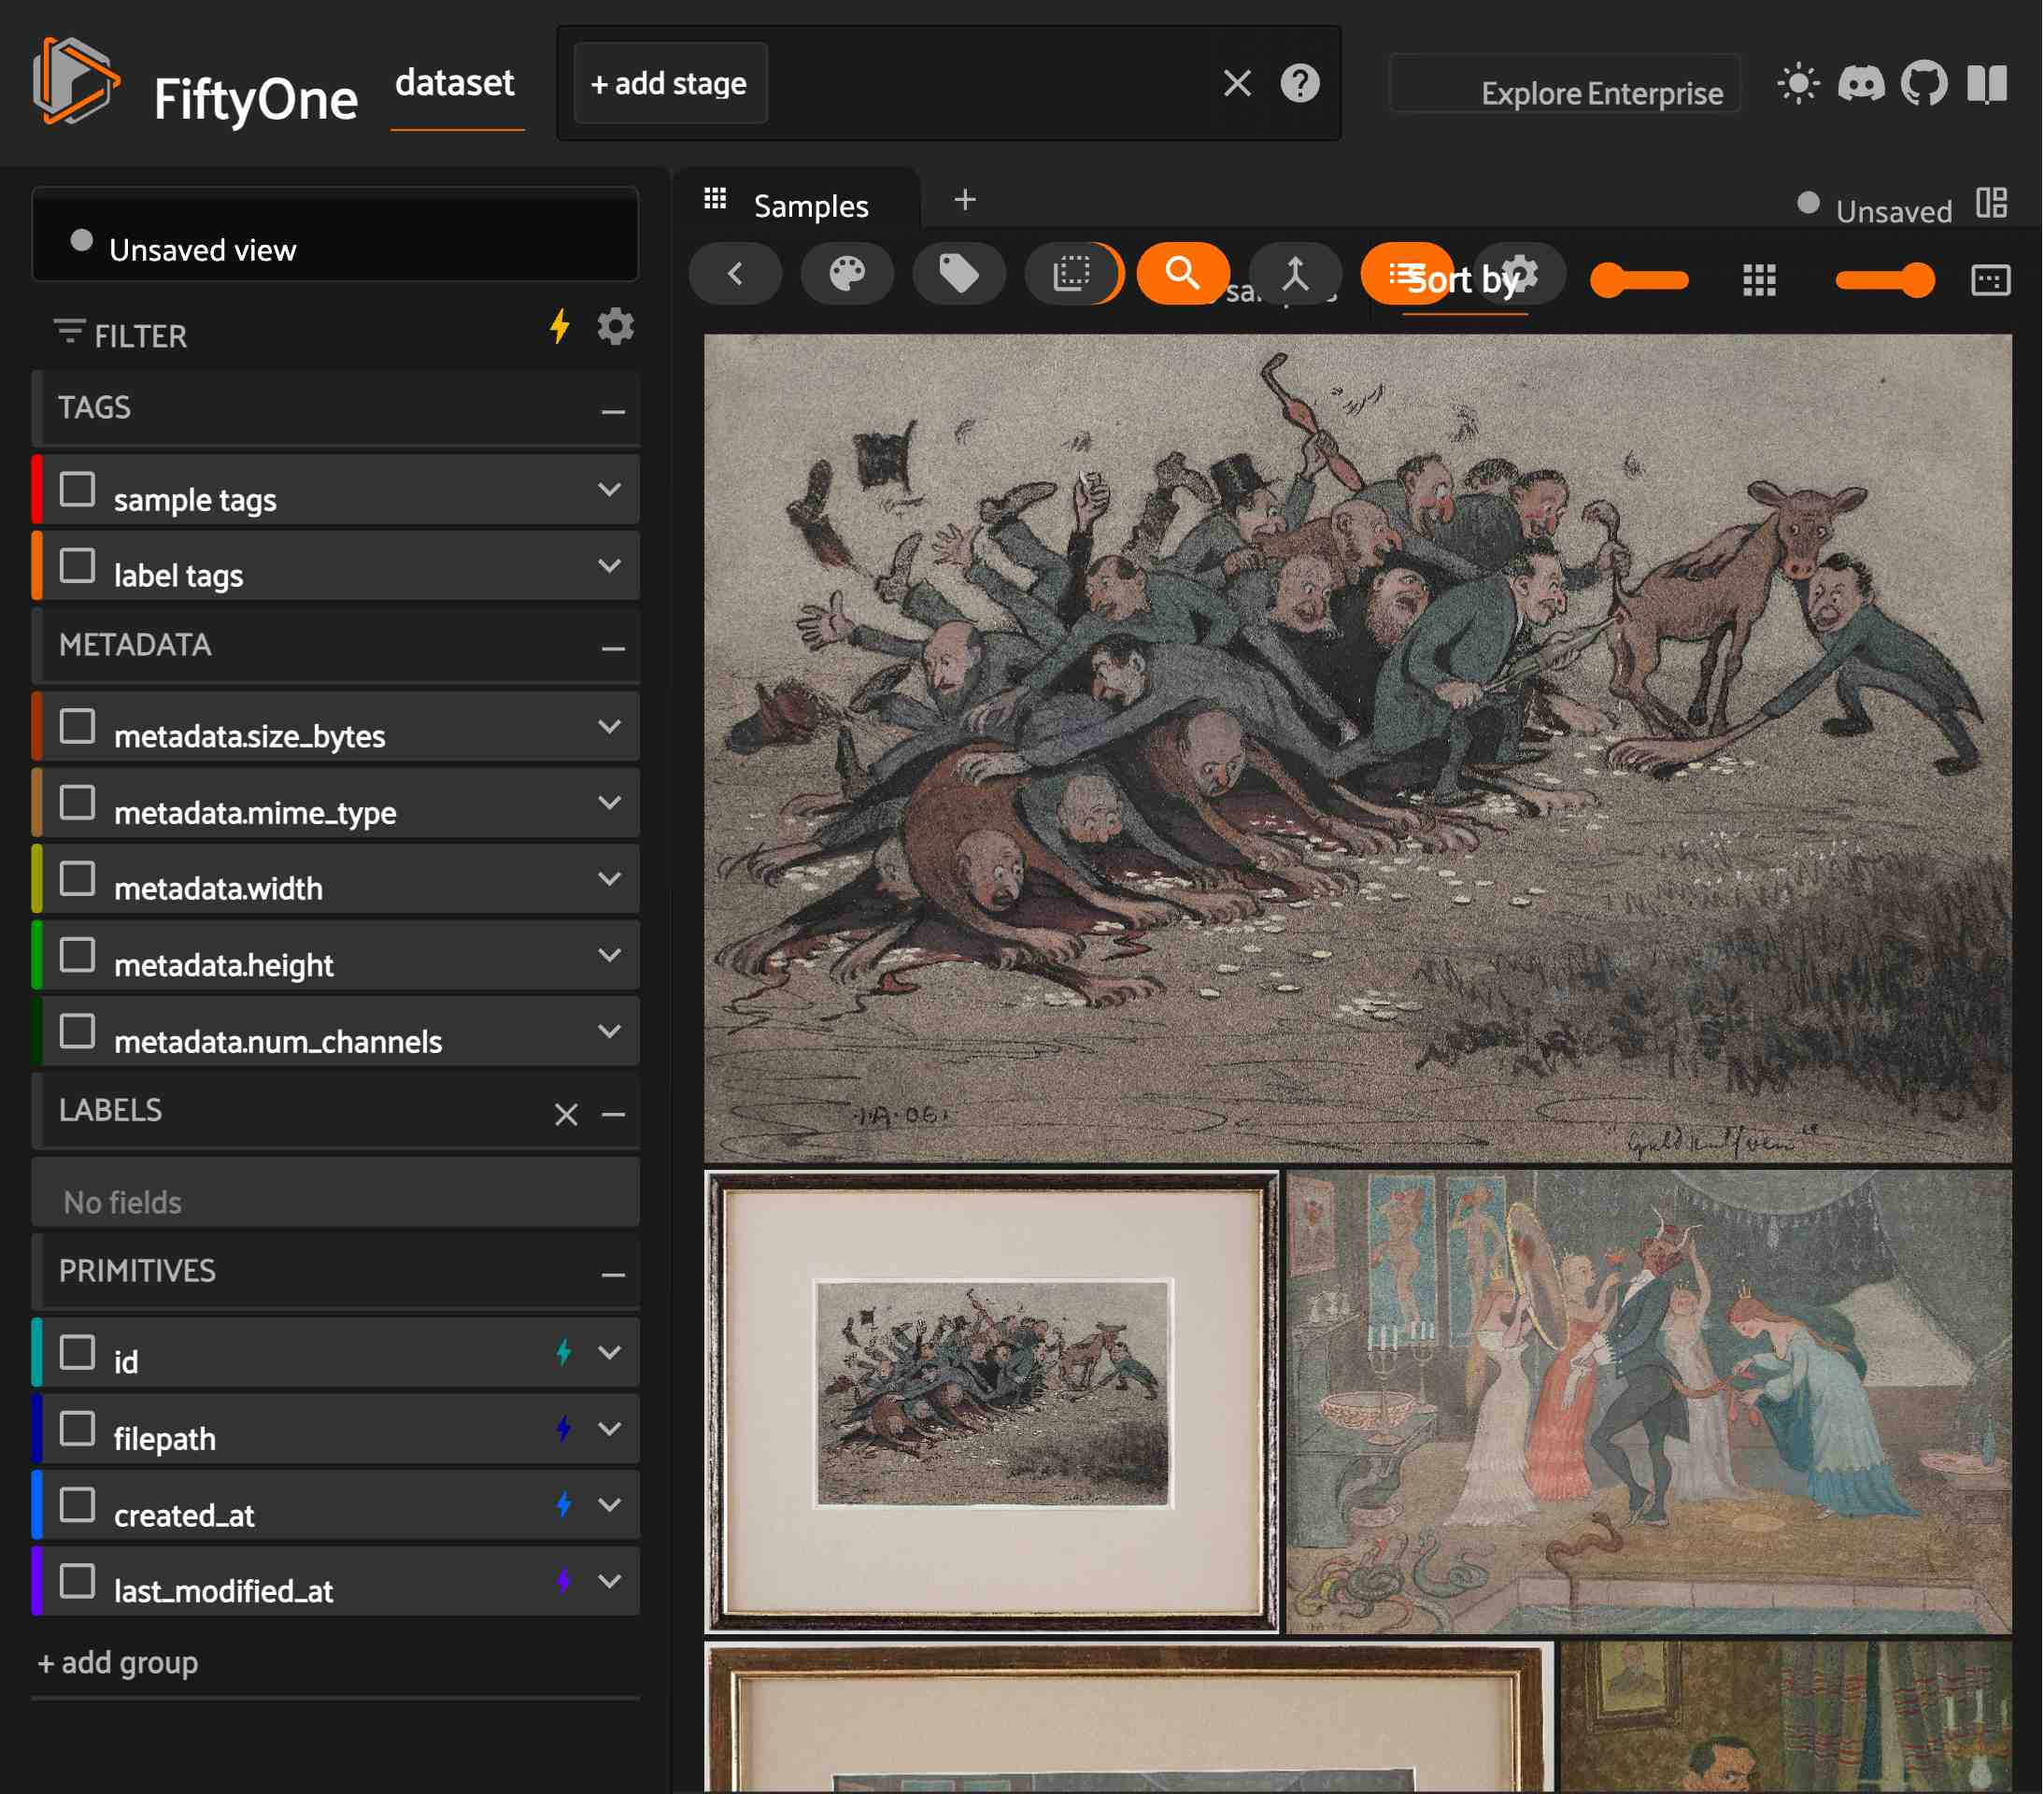

In [7]:
distances = find_neighbours(model, dataset)  # Re-run your function
# Open FiftyOne app to explore visualization
session = fo.launch_app(dataset)

Computing embeddings...
 100% |█████████████████| 165/165 [1.6m elapsed, 0s remaining, 1.6 samples/s]      
Generating visualization...
UMAP(n_jobs=1, random_state=51, verbose=True)


/Users/xkaria/anaconda3/envs/image-extractor-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/xkaria/anaconda3/envs/image-extractor-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Mon Jun 23 10:05:06 2025 Construct fuzzy simplicial set
Mon Jun 23 10:05:06 2025 Finding Nearest Neighbors
Mon Jun 23 10:05:08 2025 Finished Nearest Neighbor Search
Mon Jun 23 10:05:09 2025 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 23 10:05:10 2025 Finished embedding



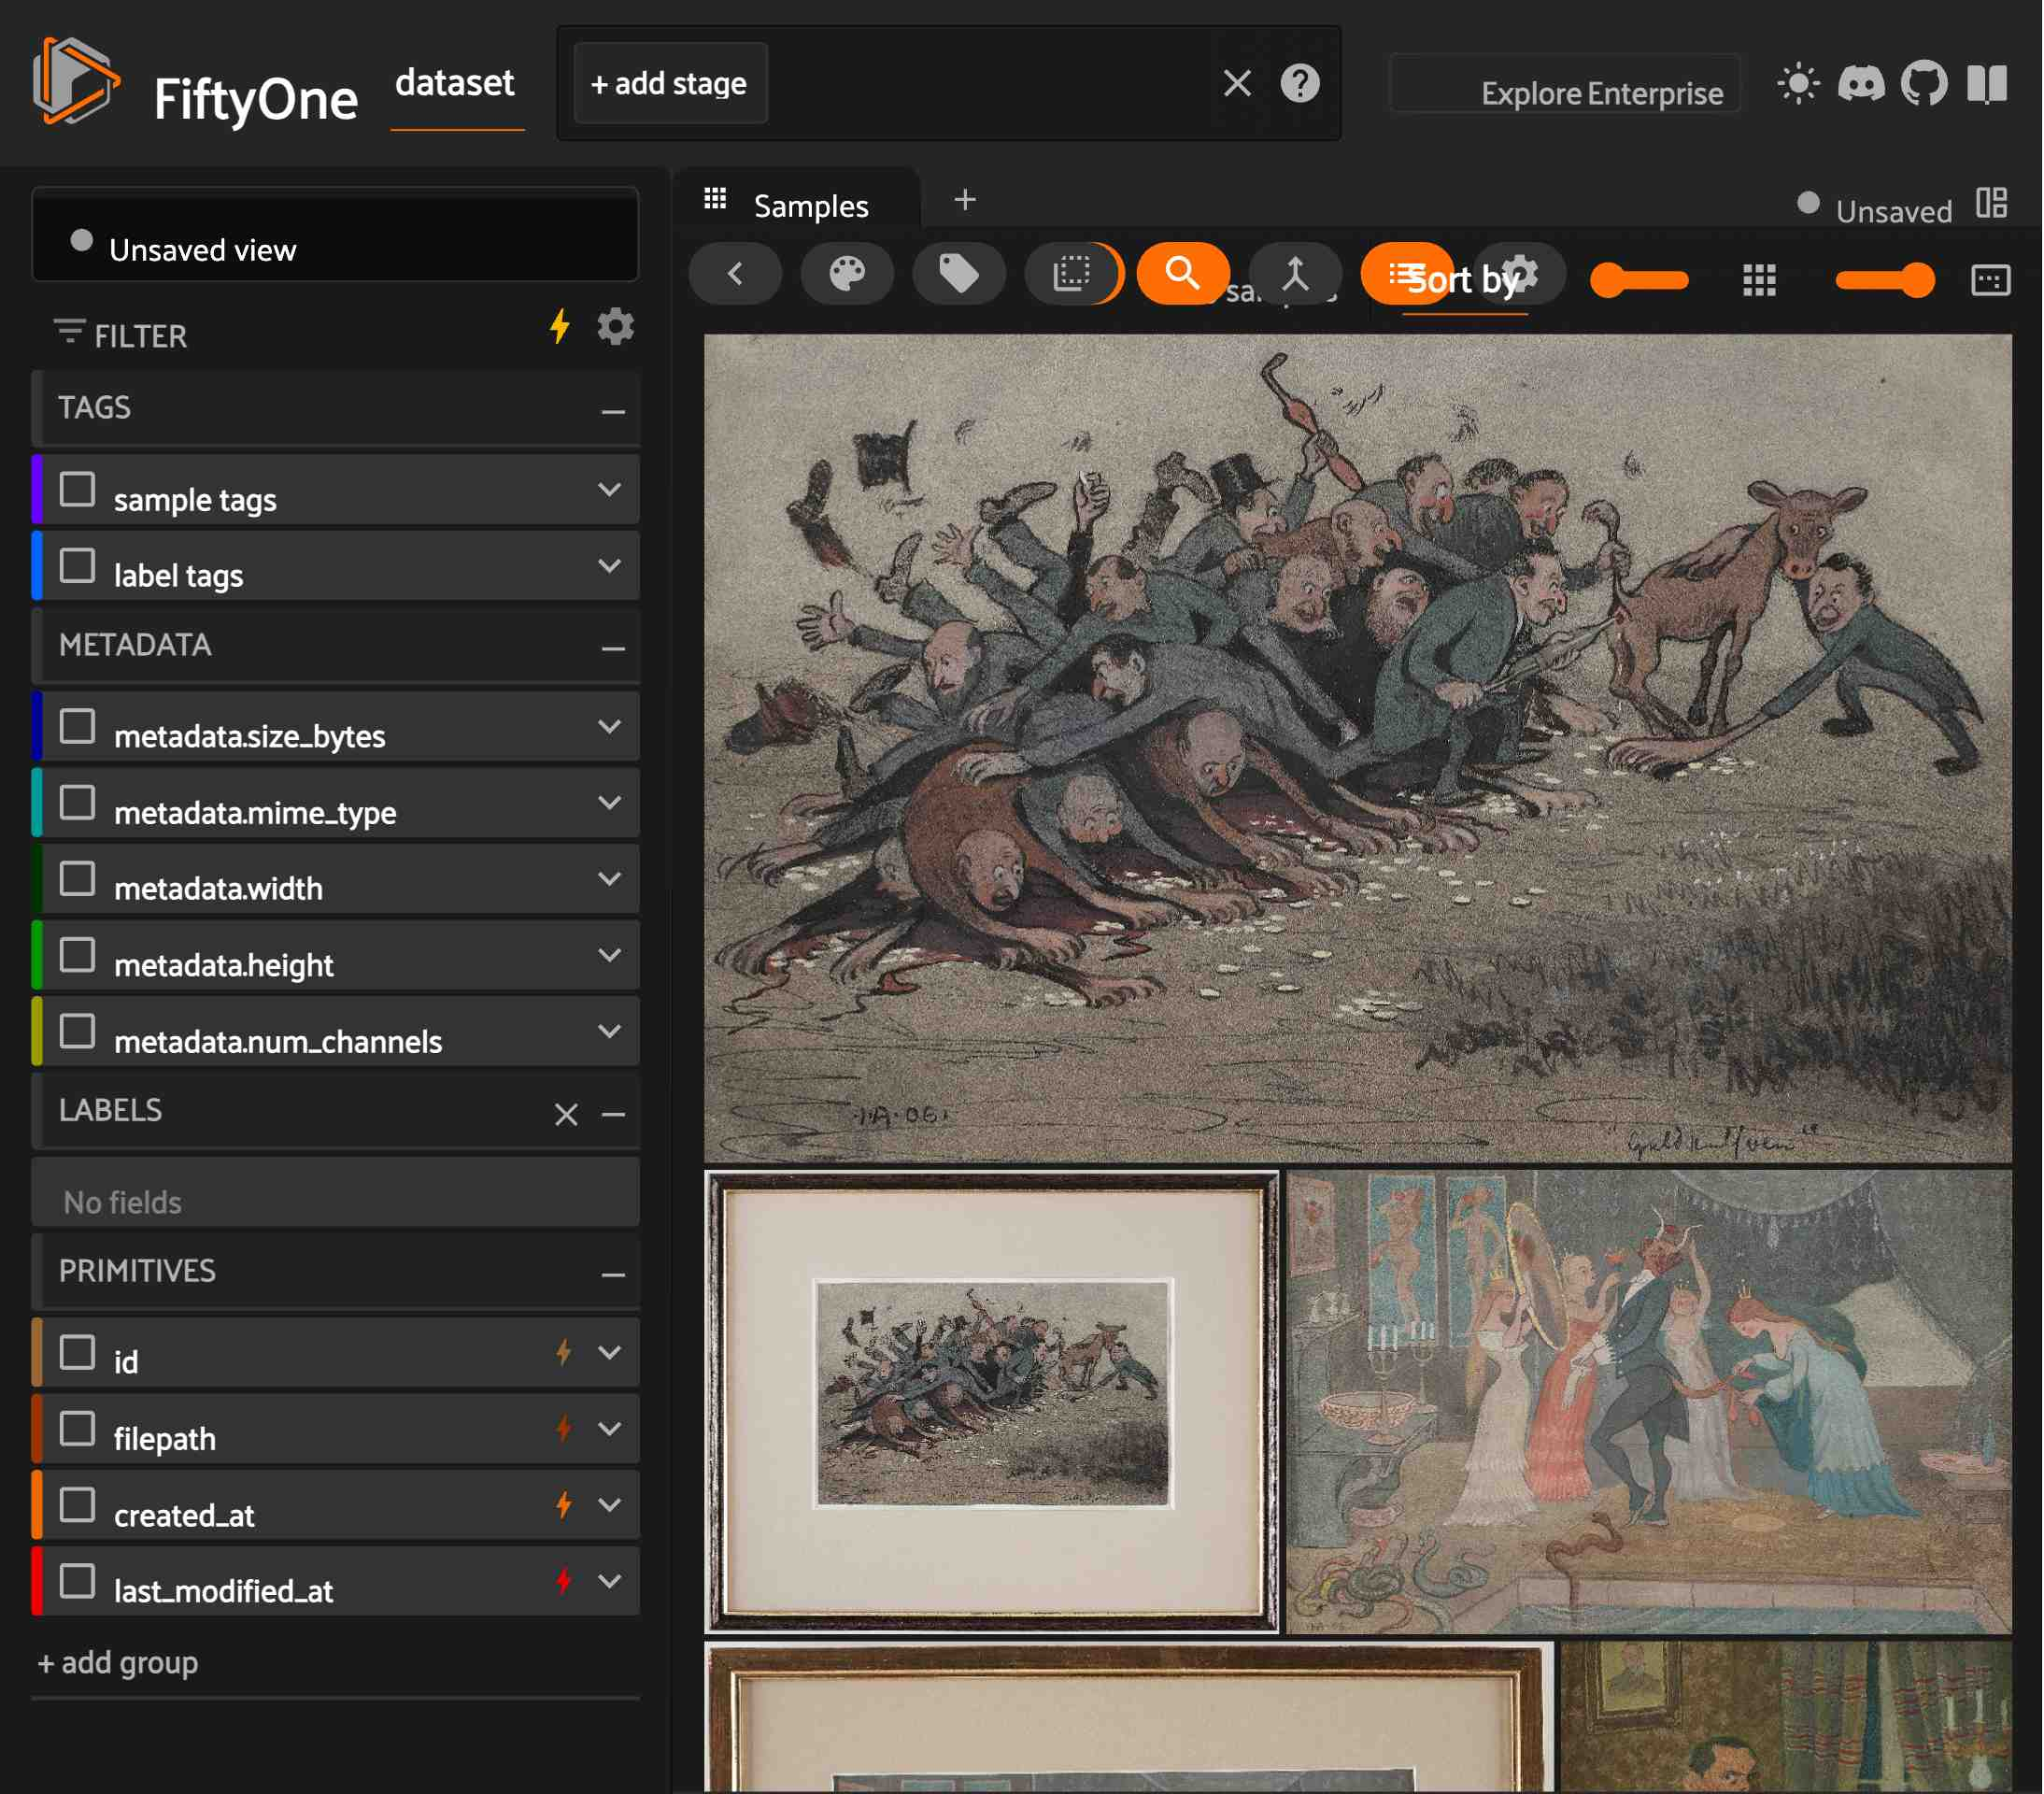

In [ ]:
import numpy as np
import umap

# Compute embeddings
# You will likely want to run this on a machine with GPU, as this requires
# running inference on 10,000 images
# Compute visualization
results = fob.compute_visualization(
    dataset, embeddings=embeddings, seed=51, brain_key="img_viz"
)

session = fo.launch_app(dataset)


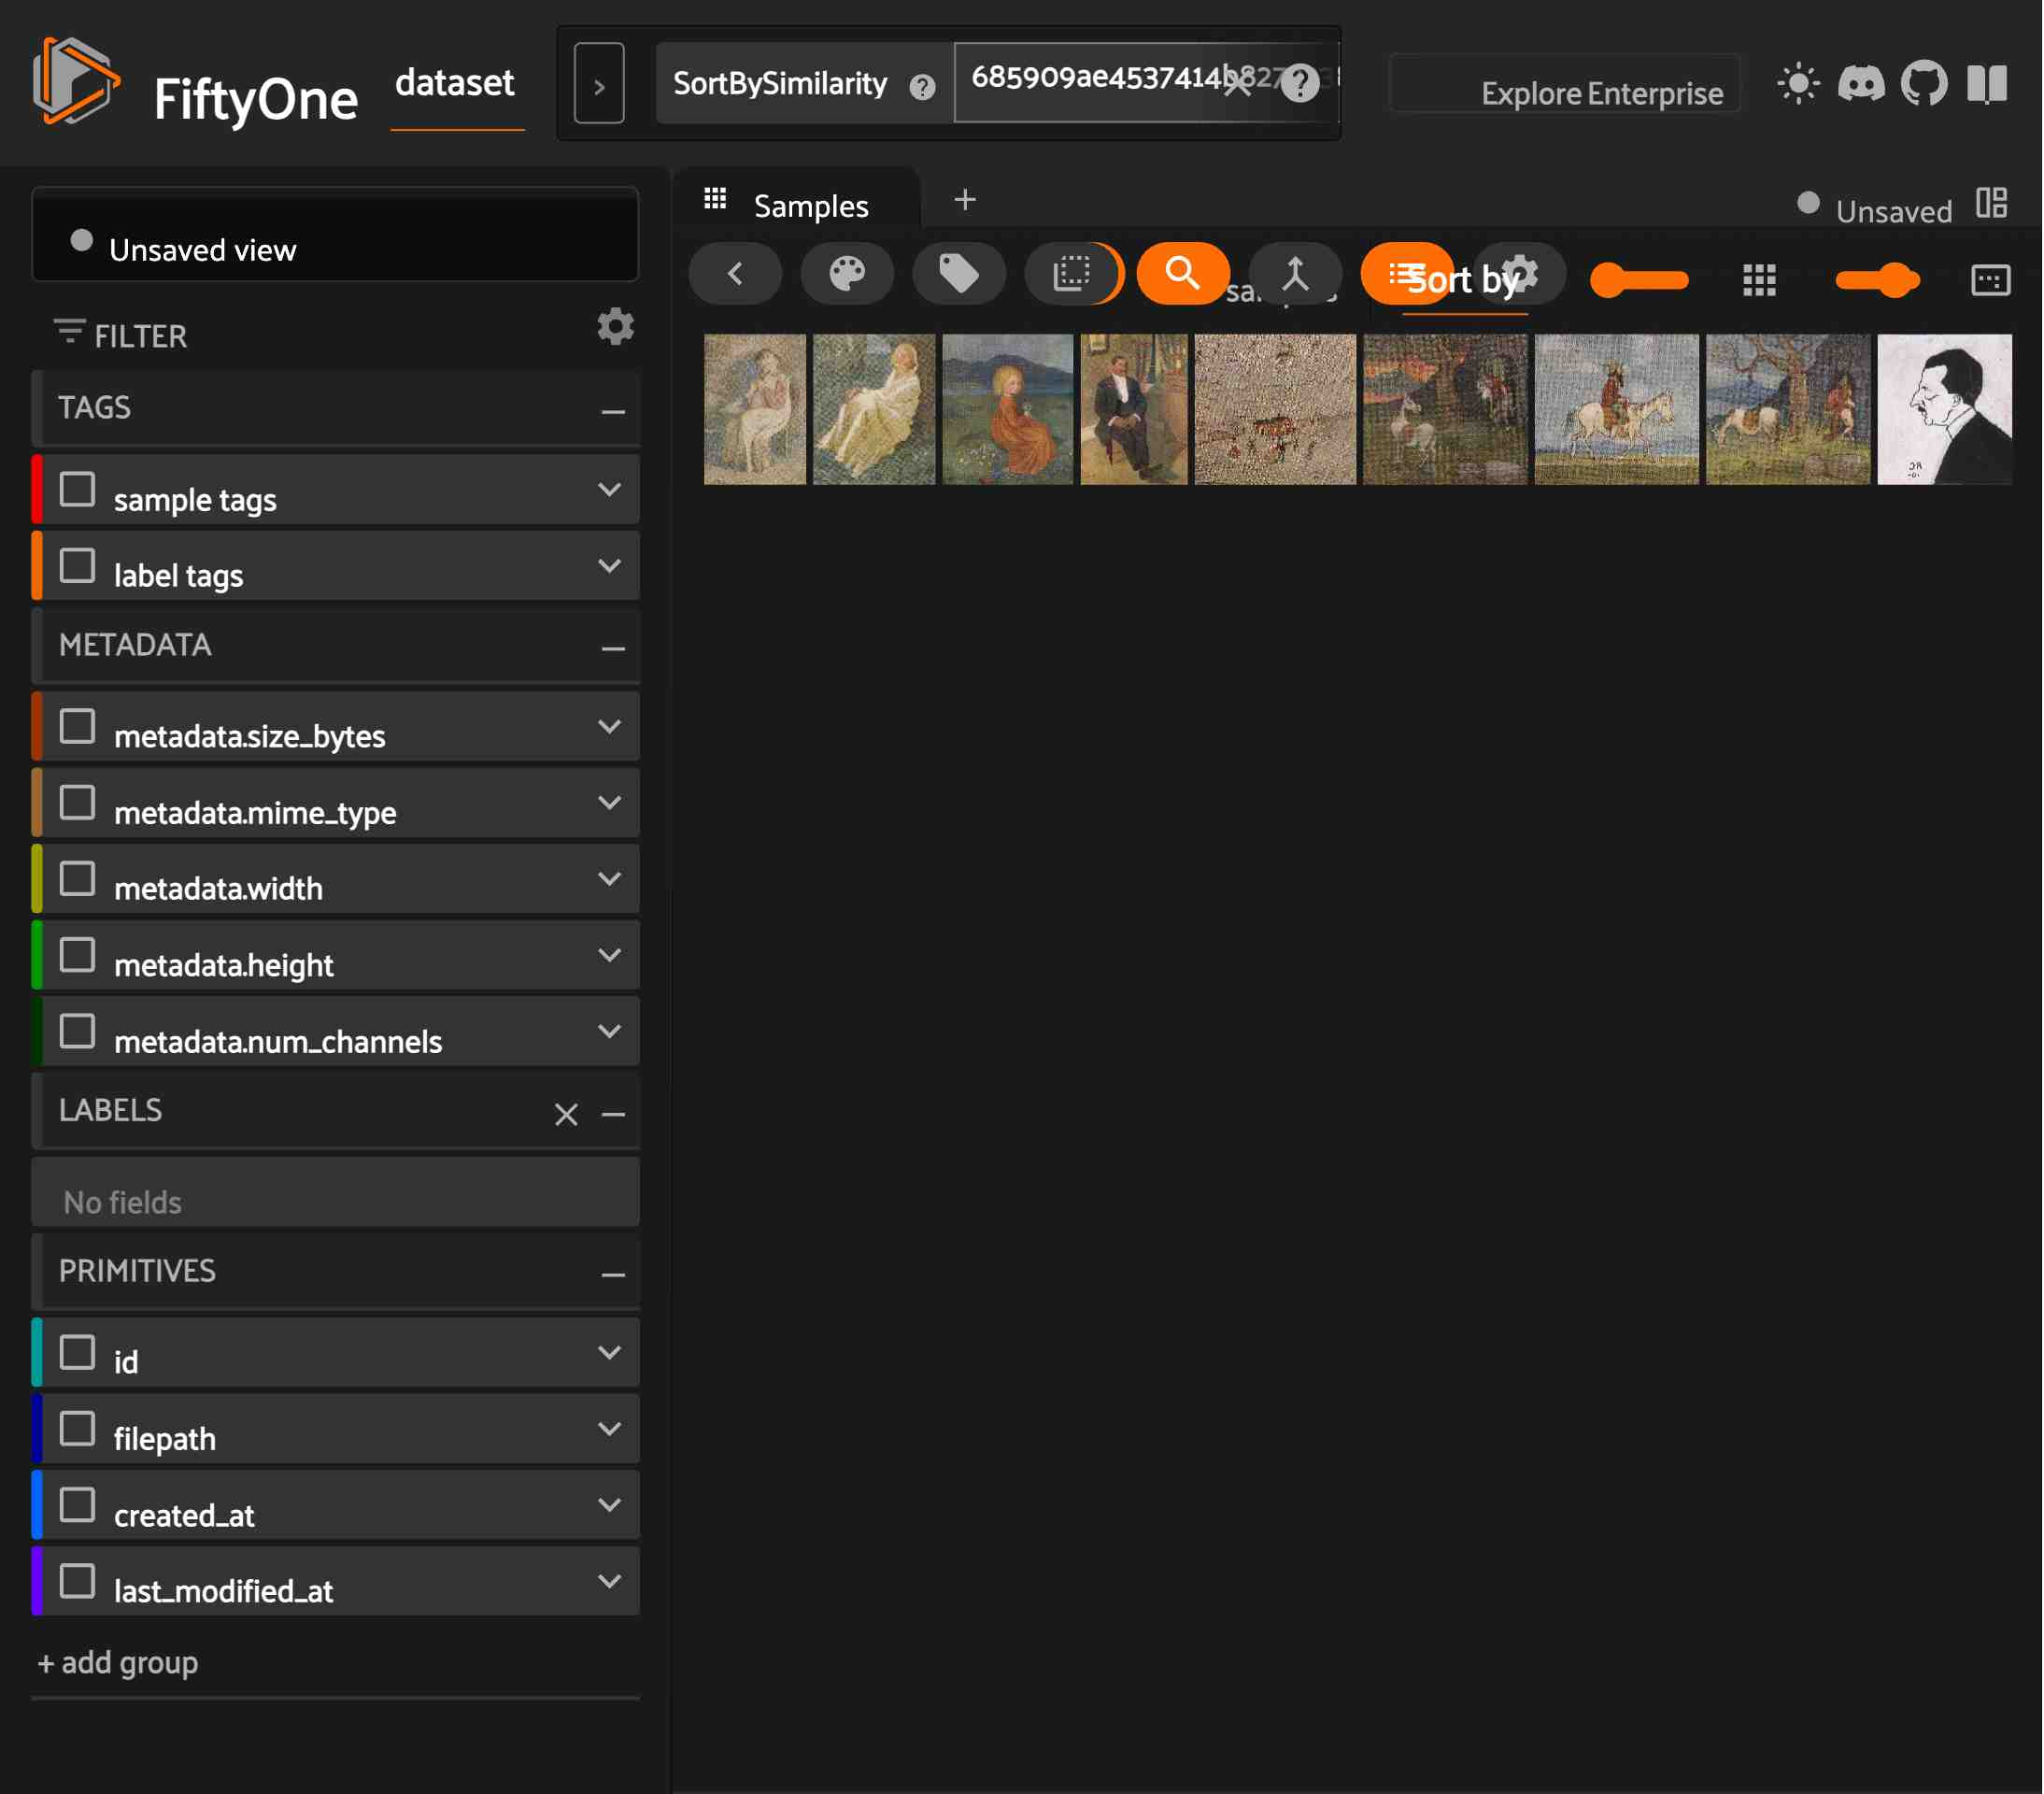


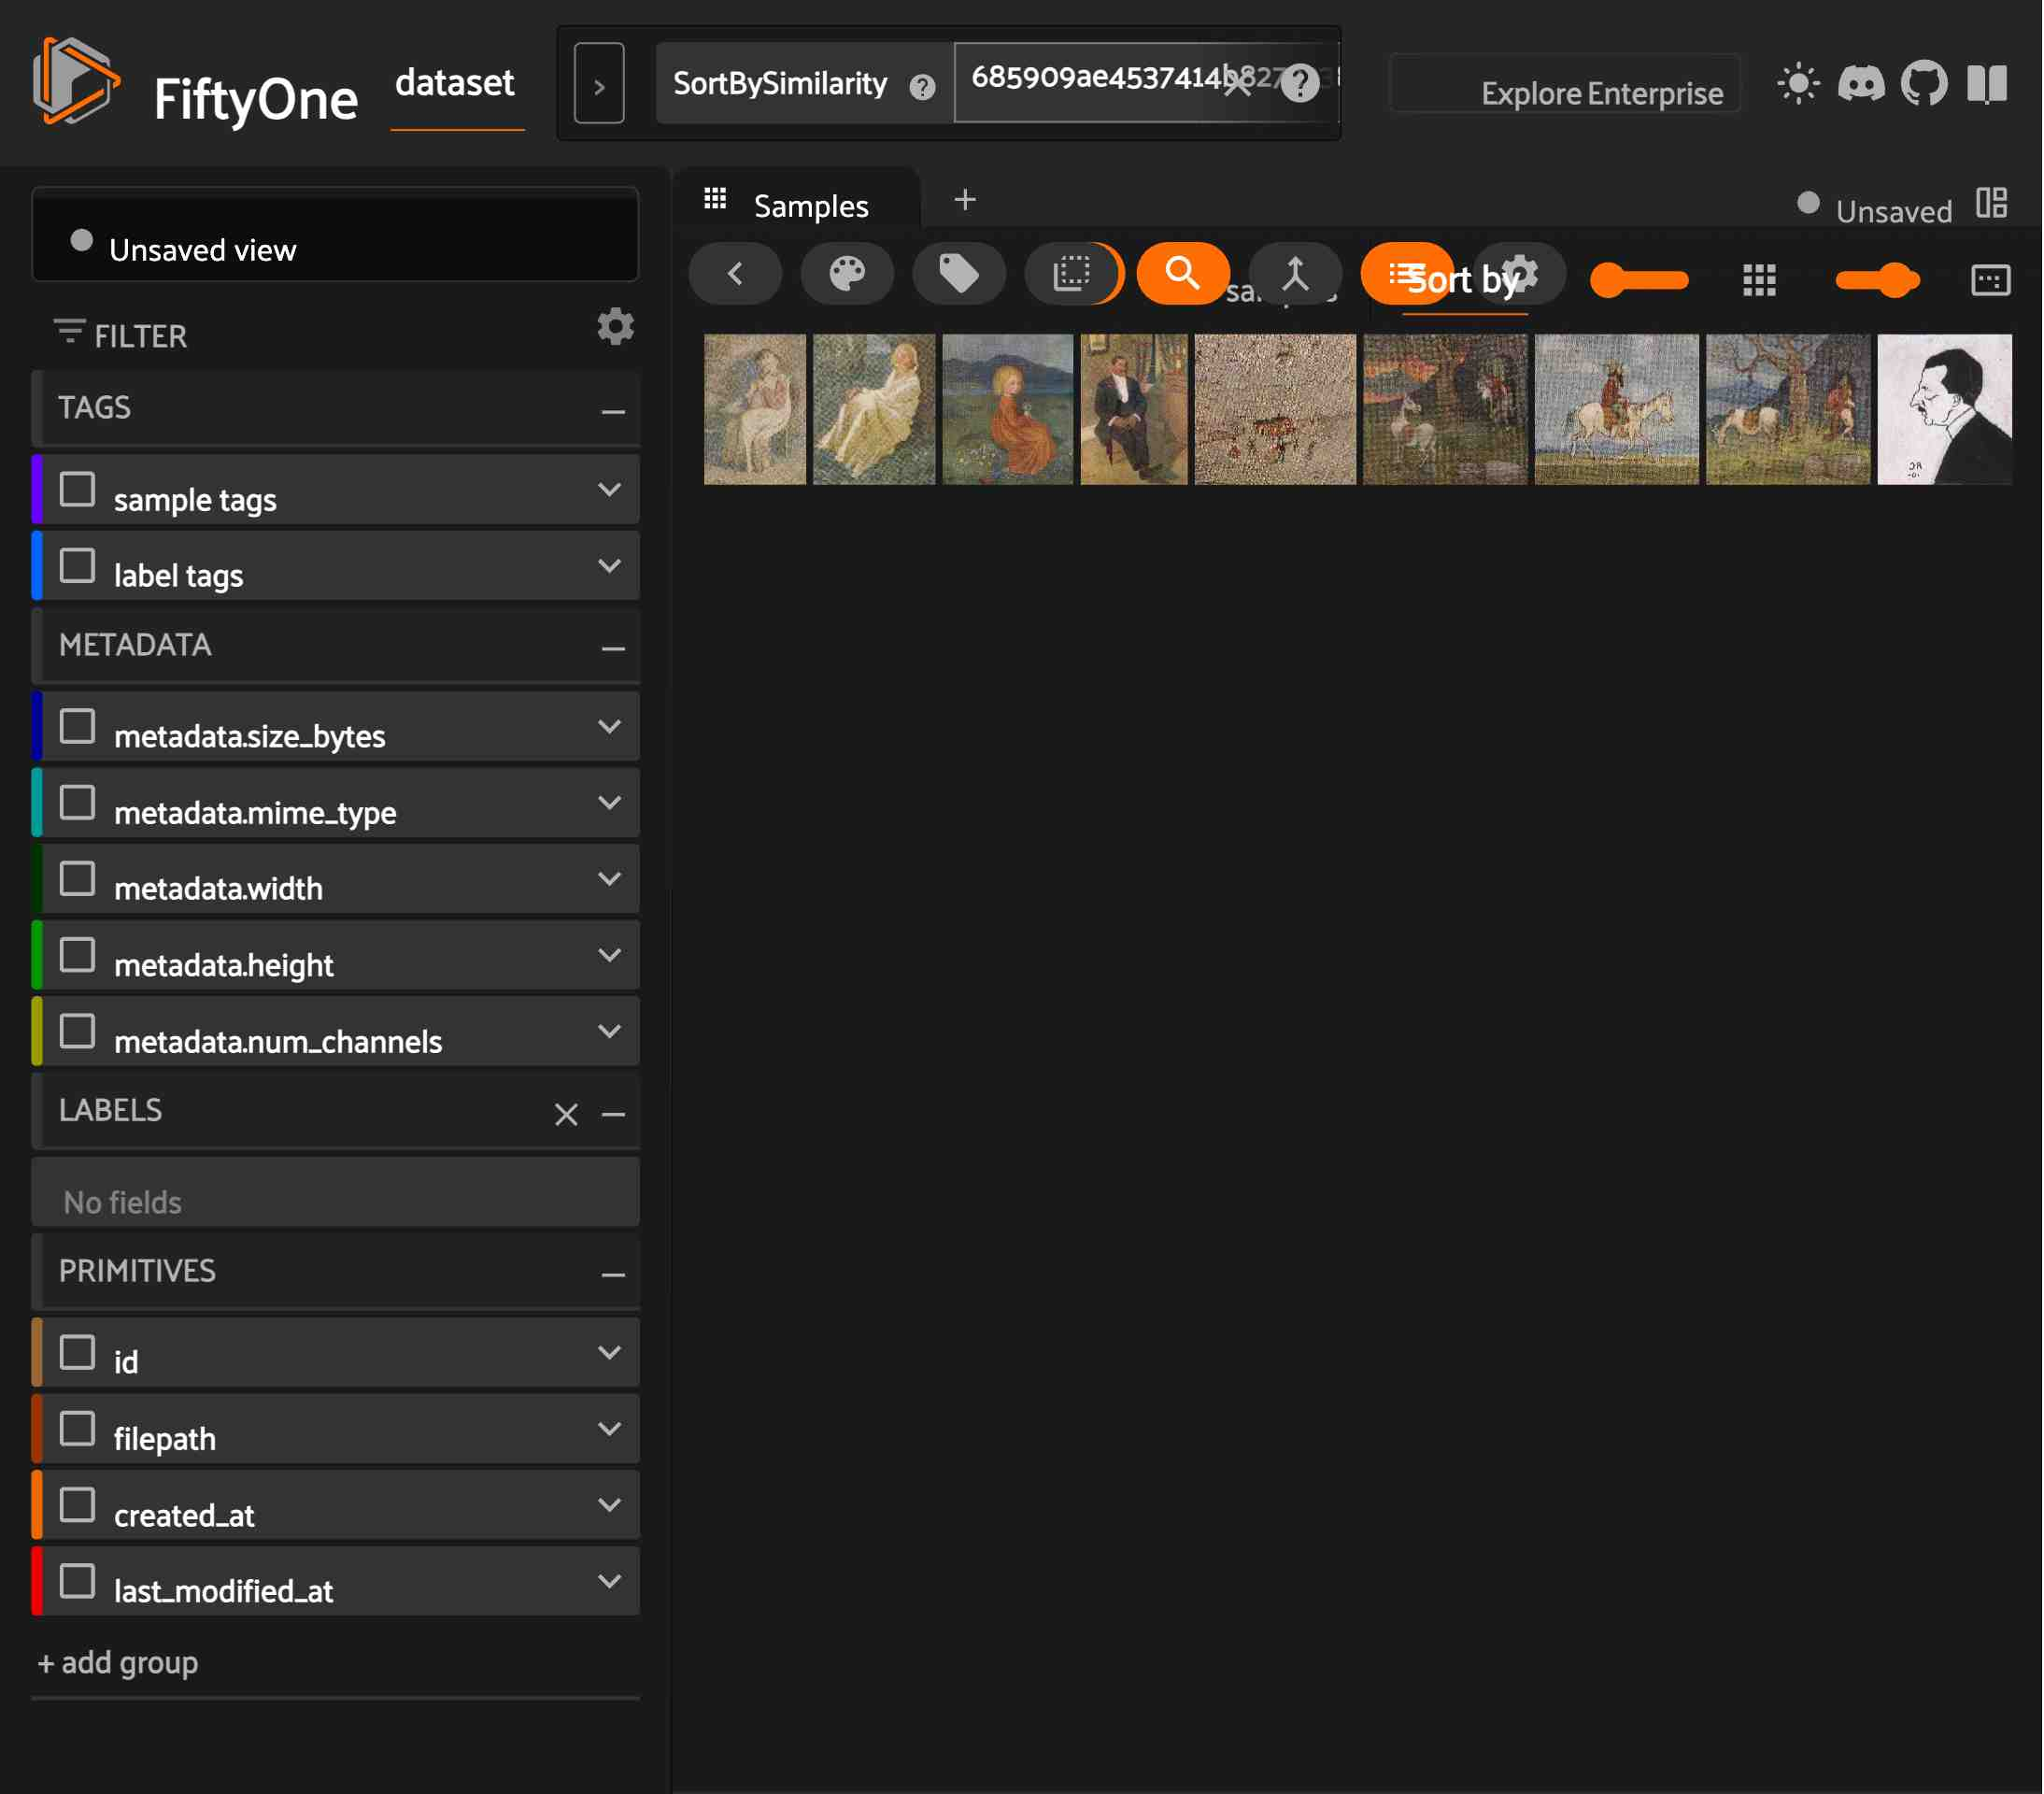

In [ ]:
import random
import fiftyone as fo

# Launch the app
session = fo.launch_app(dataset)

# Pick a random sample by ID
sample_ids = dataset.values("id")
random_id = random.choice(sample_ids)

# Get its neighbors using the brain key
neighbors_view = dataset.sort_by_similarity(
    random_id,          # ✅ pass the sample ID, not the full sample
    brain_key="img_sim",
    k=9
)

# Show the neighbors in the session
session.view = neighbors_view




In [10]:
import torch
from torchvision import models, transforms
from PIL import Image
import os
import json
import urllib.request

# Load a pre-trained model
model = models.resnet50(pretrained=True)
model.eval()


/Users/xkaria/anaconda3/envs/image-extractor-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/xkaria/anaconda3/envs/image-extractor-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/xkaria/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 43.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# Download ImageNet class index to label mapping
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels_path = "imagenet_classes.txt"
if not os.path.exists(labels_path):
    urllib.request.urlretrieve(LABELS_URL, labels_path)

with open(labels_path) as f:
    labels = [line.strip() for line in f.readlines()]


In [12]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [15]:

import open_clip
import torch
from PIL import Image
import torchvision.transforms as T
import os

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

candidate_tags = ["cat", "dog", "car", "person", "sky", "tree", "food", "building", "phone"]

def generate_tags_clip(image_dir, top_k=3):
    results = []
    texts = tokenizer(candidate_tags)
    text_features = model.encode_text(texts).detach()

    for image_name in os.listdir(image_dir):
        if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        image_path = os.path.join(image_dir, image_name)
        try:
            image = Image.open(image_path).convert("RGB")
        except:
            continue

        image_input = preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_features = model.encode_image(image_input)

            similarity = (image_features @ text_features.T).squeeze(0)
            top_tags = torch.topk(similarity, k=top_k).indices
            tags = [candidate_tags[i] for i in top_tags]
            results.append((image_name, tags))

    return results


In [16]:
pred_tags = generate_tags_clip(path)
print(pred_tags)

[('12549823_fullsize.jpg', ['phone', 'sky', 'tree']), ('2035416.jpg', ['tree', 'dog', 'cat']), ('12577849_fullsize.jpg', ['dog', 'sky', 'phone']), ('2035417-2.jpg', ['tree', 'dog', 'food']), ('12756922_fullsize.jpg', ['sky', 'dog', 'cat']), ('Flicka med bucket.jpg', ['phone', 'sky', 'dog']), ('9210519_fullsize.jpg', ['sky', 'phone', 'tree']), ('11685218_fullsize.jpg', ['sky', 'dog', 'cat']), ('gkm_diabilder_1904_001.jpg', ['phone', 'car', 'sky']), ('drake-front.jpg', ['sky', 'tree', 'phone']), ('2035417.jpg', ['dog', 'tree', 'cat']), ('arosenius_dubblettbilder234.jpg', ['cat', 'dog', 'tree']), ('arosenius_dubblettbilder220.jpg', ['tree', 'phone', 'car']), ('2035417-1.jpg', ['tree', 'cat', 'sky']), ('arosenius_dubblettbilder196.jpg', ['phone', 'car', 'tree']), ('gkm_diabilder_1907_0034b.jpg', ['tree', 'food', 'phone']), ('gkm_diabilder_1905_007.jpg', ['sky', 'tree', 'phone']), ('Flickan_och_ljuset.jpg', ['sky', 'phone', 'dog']), ('axel.jpg', ['phone', 'person', 'dog']), ('12578510_fulls

In [17]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import os

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model.eval()

def generate_tags_blip(image_dir, processor, model):
    tags = []
    for image_name in os.listdir(image_dir):
        if not image_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            continue

        image_path = os.path.join(image_dir, image_name)
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Skipping {image_name}: {e}")
            continue

        inputs = processor(image, return_tensors="pt")
        with torch.no_grad():
            output = model.generate(**inputs)
            caption = processor.decode(output[0], skip_special_tokens=True)
            tags.append((image_name, caption))

    return tags


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [18]:
pred_tags_blip = generate_tags_blip(path, processor, model)
print(pred_tags_blip)

[('12549823_fullsize.jpg', 'a painting of a girl with a flower in her hand'), ('2035416.jpg', 'a painting of a woman sitting on a rock'), ('12577849_fullsize.jpg', 'a painting of a crowd of people in a field'), ('2035417-2.jpg', 'a drawing of a man holding a baby'), ('12756922_fullsize.jpg', 'a painting of a woman with a dog'), ('Flicka med bucket.jpg', 'a painting of a girl in a field'), ('9210519_fullsize.jpg', 'a painting of a boat with a sail'), ('11685218_fullsize.jpg', 'a painting of a man riding a horse'), ('gkm_diabilder_1904_001.jpg', 'a drawing of a man with a beard'), ('drake-front.jpg', 'a painting of a bird flying over a lake'), ('2035417.jpg', 'a drawing of a man and woman in a room'), ('arosenius_dubblettbilder234.jpg', 'a drawing of a woman holding a baby'), ('arosenius_dubblettbilder220.jpg', 'a painting of a man in a suit and tie'), ('2035417-1.jpg', 'a piece of paper with a handwritten message'), ('arosenius_dubblettbilder196.jpg', 'a drawing of a man in a hat'), ('g

In [22]:
# Ensure numpy is properly installed
 
import os
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
import fiftyone as fo

# Load the BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model.eval()

def generate_tags_blip(image_dir, dataset):
    # Create a FiftyOne Dataset to store image and captions

    for image_name in os.listdir(image_dir):
        if not image_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            continue

        image_path = os.path.join(image_dir, image_name)
        try:
            # Open image
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Skipping {image_name}: {e}")
            continue

        # Process image and generate caption
        inputs = processor(image, return_tensors="pt")
        with torch.no_grad():
            output = model.generate(**inputs)
            caption = processor.decode(output[0], skip_special_tokens=True)

        # Add the image and its caption to the FiftyOne dataset
        sample = fo.Sample(filepath=image_path)
        sample["caption"] = caption  # Add the caption as a field
        dataset.add_sample(sample)

    return dataset

# Generate the dataset and visualize
dataset = fo.Dataset(name="dataset_blip_test")  # or any unique name
path = './data/test'
dataset = generate_tags_blip(path, dataset)

# Launch the FiftyOne app to visualize
session = fo.launch_app(dataset)
